In [3]:
import time
import optuna
import joblib
import mlflow
import numpy as np
import pandas as pd
import seaborn as sns
import category_encoders as ce
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler, RobustScaler, OneHotEncoder, PowerTransformer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import recall_score, precision_score
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier


# Definindo a seed para o random state
rs = 840

In [4]:
# Lendo os dados
data_fraud = pd.read_csv("../data/processed/data_fraud.csv", index_col=0)

In [5]:
# Dividindo em variáveis explicativas e target
x = data_fraud.drop(["score_fraude_modelo", "fraude"], axis = 1)
y = data_fraud["fraude"]

Vamos relembrar pontos importantes que descobrimos na etapa de análise:

- As variáveis **pais** e **categoria_produto** possuem uma alta cardinalidade.
- As variáveis **pais** e **categoria_produto** possuem muitos valores com contagem de categorias iguais.
- Ainda existem variáveis com valores ausentes, tanto categóricas, como numéricas.
- O target está desbalanceado.

Sabendo disso, vamos desenhar como a etapa de experimentação irá se desenrolar:

1. Os dados serão divididos em treino, dev e teste. Iremos treinar o algoritmo
com os dados de treino, fazer a tunagem com os dados de dev, e, por fim, validar
com os dados de teste.
2. Será criado um esqueleto para o pipeline de transformação, consistindo
em um imputer e scaler(quando necessário) para as variáveis numéricas e um imputer 
e um encoder para as categóricas.
    
    2.1. Não usaremos o OneHotEncoder para as colunas com uma alta quantidade de
    categorias únicas, pois isso elevaria a dimensionalidade dos dados.

    2.2. Também não será utilizado o CountEncoder nas colunas com uma alta quantidade
    de categorias únicas, pois algumas categorias apresentam a mesma quantidade de registros.

3. A princípio, testaremos alguns modelos base com o StandardScaler (quando necessário),
OneHotEncoder para as features de baixa dimensão e CatBoostEncoder para as de alta
dimensão.
3. As métricas avaliadas serão o Recall e a Latência média.
4. Os modelos mais promissores entrarão em outra rodada de experimentos, dessa
vez para testar outras combinações de encoders e scalers (se necessário).

## Realizando os experimentos


In [6]:
# Define o local para salvar os exoerimentos
mlflow.set_tracking_uri('../mlruns')

In [7]:
# Divindo os dados em treino, dev e teste
x_treino, x_teste, y_treino, y_teste = train_test_split(x,
                                                        y,
                                                        test_size=0.3,
                                                        stratify=y,
                                                        random_state=rs)

x_dev, x_teste, y_dev, y_teste = train_test_split(x_teste, 
                                                  y_teste,
                                                  stratify=y_teste,
                                                  test_size=0.5,
                                                  random_state=rs)

# Dividindo features numéricas de categóricas
cat_cols_high_dim = ["pais", "categoria_produto"]
cat_cols = [col for col in x_treino.select_dtypes("object").columns if col not in cat_cols_high_dim]
num_cols = x_treino.select_dtypes(["int", "float"]).columns

# Setando o KFold
kf = StratifiedKFold(shuffle=True, random_state=rs)

In [8]:
# Definindo os dicionarios com os modelos e etapas de pre-processamento que serã utilizadas

dict_models_scale_sensitive = {"LR": LogisticRegression(random_state=rs,
                                                        class_weight='balanced')}

dict_models_tree_based = {"LGBM": LGBMClassifier(is_unbalance=True,
                                                 objective= 'binary',
                                                 random_state=rs),
                          "XGB": XGBClassifier(random_state=rs,
                                               objective='binary:hinge'),
                          "RF": RandomForestClassifier(class_weight='balanced',
                                                       random_state=rs)}

# Criando dicionário com os encoders
dict_encoders = {"OHE": OneHotEncoder(drop='first'),
                 "TE": ce.TargetEncoder(),
                 "BE": ce.BinaryEncoder(),
                 "ME": ce.MEstimateEncoder(),
                 "CE": ce.CatBoostEncoder(),
                 "GE":ce.GrayEncoder(),
                 "CTE":ce.CountEncoder()}

dict_imputers_num = {"SIAVG": SimpleImputer(strategy='mean'),
                     "SIMEDIAN": SimpleImputer(strategy='median')}

dict_scalers = {"SS": StandardScaler(),
                "RS": RobustScaler()}

# Criando dicionário com os transformers
dict_transformers = {"PT": PowerTransformer()}

In [9]:
# Criando/acessando o experimento
mlflow.set_experiment('Comparando modelos base')
#
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_scale_sensitive.items():
#
#    # Gerando a tag de identificação do modelo
#    nome_modelo = f'{tag}'
#
#    with mlflow.start_run(run_name=nome_modelo):
#
#        # Criando os pipeline com os transformers
#        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                            ('encoder', OneHotEncoder(drop='first'))])
#    
#        # Criando os pipeline com os transformers
#        pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                        ('encoder_hd', ce.CatBoostEncoder())])
#    
#        pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
#                            ('scaler', StandardScaler())])
#    
#        # Criando o transformador
#        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                        ('num', pipe_num, num_cols),
#                                        ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                        remainder="passthrough")
#    
#        # Criando o pipeline final
#        pipe = Pipeline([('transformer', transformer),
#                        ('model', model)])
#    
#        # Executando o cross validation
#        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#        # Calculando a média das métricas
#        mean_score = cross_val_scores.mean()           
#    
#        # Salvando a métrica da folder 1
#        mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#        # Salvando a métrica da folder 2
#        mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#        # Salvando a métrica da folder 3
#        mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#        # Salvando a métrica da folder 4
#        mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#        # Salvando a métrica da folder 5
#        mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#        # Salvando as métricas
#        mlflow.log_metric('recall_mean', mean_score)
#    
#        # Treinando o algoritmo
#        pipe.fit(x_treino, y_treino)
#    
#        # Calculando a latência média
#        latency_list = []
#    
#        for _, row in x_treino[:1000].iterrows():
#        
#            # Início da contagem de tempo
#            start_time = time.time()
#    
#            # Extrair os recursos da linha
#            features = row.values.reshape(1, -1)
#    
#            # Fazer a previsão para a linha individual
#            prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#            # Encerra a contagem
#            end_time = time.time()
#            atomic_time = end_time - start_time
#    
#            # Transforma segundo em milissegundo
#            atomic_milissec = atomic_time * 1000
#    
#            # Adiciona o tempo em uma lista
#            latency_list.append(atomic_milissec)
#    
#        # calcula a média 
#        mlflow.log_metric("Latência média", np.mean(latency_list))

<Experiment: artifact_location='/home/daniel/Documents/preditor_fraude/notebooks/../mlruns/713216335783287400', creation_time=1711999437655, experiment_id='713216335783287400', last_update_time=1711999437655, lifecycle_stage='active', name='Comparando modelos base', tags={}>

In [10]:
## Iniciando os experimentos sem transformers
#for tag, model in dict_models_tree_based.items():
#
#    # Gerando a tag de identificação do modelo
#    nome_modelo = f'{tag}'
#
#    with mlflow.start_run(run_name=nome_modelo):
#
#        # Criando os pipeline com os transformers
#        pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                            ('encoder', OneHotEncoder(drop='first'))])
#    
#        # Criando os pipeline com os transformers
#        pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                        ('encoder_hd', ce.CatBoostEncoder())])
#    
#        pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median"))])
#    
#        # Criando o transformador
#        transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                        ('num', pipe_num, num_cols),
#                                        ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                        remainder="passthrough")
#    
#        # Criando o pipeline final
#        pipe = Pipeline([('transformer', transformer),
#                        ('model', model)])
#    
#        # Executando o cross validation
#        cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#    
#        # Calculando a média das métricas
#        mean_score = cross_val_scores.mean()           
#    
#        # Salvando a métrica da folder 1
#        mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#    
#        # Salvando a métrica da folder 2
#        mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#    
#        # Salvando a métrica da folder 3
#        mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#    
#        # Salvando a métrica da folder 4
#        mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#    
#        # Salvando a métrica da folder 5
#        mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#    
#        # Salvando as métricas
#        mlflow.log_metric('recall_mean', mean_score)
#    
#        # Treinando o algoritmo
#        pipe.fit(x_treino, y_treino)
#    
#        # Calculando a latência média
#        latency_list = []
#    
#        for _, row in x_treino[:1000].iterrows():
#        
#            # Início da contagem de tempo
#            start_time = time.time()
#    
#            # Extrair os recursos da linha
#            features = row.values.reshape(1, -1)
#    
#            # Fazer a previsão para a linha individual
#            prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#    
#            # Encerra a contagem
#            end_time = time.time()
#            atomic_time = end_time - start_time
#    
#            # Transforma segundo em milissegundo
#            atomic_milissec = atomic_time * 1000
#    
#            # Adiciona o tempo em uma lista
#            latency_list.append(atomic_milissec)
#    
#        # calcula a média 
#        mlflow.log_metric("Latência média", np.mean(latency_list))

In [11]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.recall_mean',
                       'metrics.Latência média', 'metrics.recall_fold_1', 
                       'metrics.recall_fold_2', 'metrics.recall_fold_3', 
                       'metrics.recall_fold_4', 'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
3,LR,0.674476,23.068824,0.665714,0.672381,0.673333,0.673333,0.687619
2,LGBM,0.638857,38.432095,0.629524,0.622857,0.647619,0.644762,0.649524
1,XGB,0.107810,70.765401,0.108571,0.093333,0.115238,0.110476,0.111429
0,RF,0.058286,40.490916,0.064762,0.049524,0.060000,0.058095,0.059048


Dos modelos testados, apenas o **LightGBM** e a **Regressão Logística** tiveram
um bom resultado. 

- O **Recall** do **LightGBM** é cerca de **0.5% superior** ao da **Regressão**.
- A **latência** do **LightGBM** é cerca de **76% maior** do que a da **Regressão**.

Dado esses aspectos, a Regressão Logística é a melhor opção.

In [12]:
# Criando/acessando o experimento
mlflow.set_experiment('Comparando regressões')
#
## Iniciando os experimentos com regressões
#for tag_encoder, encoder in dict_encoders.items():
#    for tag_scaler, scaler in dict_scalers.items():
#        for tag_imputer, imputer in dict_imputers_num.items():
#        
#            # Gerando a tag de identificação do modelo
#            nome_modelo = f'LR_{tag_encoder}_{tag_scaler}_{tag_imputer}'
#
#            with mlflow.start_run(run_name=nome_modelo):
#            
#                # Criando os pipeline com os transformers
#                pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder', encoder)])
#
#                # Criando os pipeline com os transformers
#                pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                                ('encoder_hd', ce.CatBoostEncoder())])
#
#                pipe_num = Pipeline([('imputer_num', imputer),
#                                     ('scaler', scaler)])
#
#                # Criando o transformador
#                transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                                ('num', pipe_num, num_cols),
#                                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                                remainder="passthrough")
#
#                # Criando o pipeline final
#                pipe = Pipeline([('transformer', transformer),
#                                ('model', LogisticRegression(class_weight='balanced',
#                                                             random_state=rs))])
#
#                # Executando o cross validation
#                cross_val_scores = cross_val_score(pipe, x_treino, y_treino, cv=kf, scoring='recall')
#
#                # Calculando a média das métricas
#                mean_score = cross_val_scores.mean()           
#
#                # Salvando a métrica da folder 1
#                mlflow.log_metric('recall_fold_1', cross_val_scores[0])
#
#                # Salvando a métrica da folder 2
#                mlflow.log_metric('recall_fold_2', cross_val_scores[1])
#
#                # Salvando a métrica da folder 3
#                mlflow.log_metric('recall_fold_3', cross_val_scores[2])
#
#                # Salvando a métrica da folder 4
#                mlflow.log_metric('recall_fold_4', cross_val_scores[3])
#
#                # Salvando a métrica da folder 5
#                mlflow.log_metric('recall_fold_5', cross_val_scores[4])
#
#                # Salvando as métricas
#                mlflow.log_metric('recall_mean', mean_score)
#
#                # Treinando o algoritmo
#                pipe.fit(x_treino, y_treino)
#
#                # Calculando a latência média
#                latency_list = []
#
#                for _, row in x_treino[:1000].iterrows():
#                
#                    # Início da contagem de tempo
#                    start_time = time.time()
#
#                    # Extrair os recursos da linha
#                    features = row.values.reshape(1, -1)
#
#                    # Fazer a previsão para a linha individual
#                    prediction = pipe.predict(pd.DataFrame(features, columns = x_treino.columns.to_list()))
#
#                    # Encerra a contagem
#                    end_time = time.time()
#                    atomic_time = end_time - start_time
#
#                    # Transforma segundo em milissegundo
#                    atomic_milissec = atomic_time * 1000
#
#                    # Adiciona o tempo em uma lista
#                    latency_list.append(atomic_milissec)
#
#                # calcula a média 
#                mlflow.log_metric("Latência média", np.mean(latency_list))
#

<Experiment: artifact_location='/home/daniel/Documents/preditor_fraude/notebooks/../mlruns/740633817162600753', creation_time=1712000121551, experiment_id='740633817162600753', last_update_time=1712000121551, lifecycle_stage='active', name='Comparando regressões', tags={}>

In [13]:
# Definindo as colunas de interesse
colunas_para_buscar = ["tags.mlflow.runName", 'metrics.recall_mean',
                       'metrics.Latência média', 'metrics.recall_fold_1', 
                       'metrics.recall_fold_2', 'metrics.recall_fold_3', 
                       'metrics.recall_fold_4', 'metrics.recall_fold_5']

# Buscando os melhores modelos
runs = mlflow.search_runs()[colunas_para_buscar]

# Ordenando por recall médio
runs.sort_values(by="metrics.recall_mean", ascending=False)

,tags.mlflow.runName,metrics.recall_mean,metrics.Latência média,metrics.recall_fold_1,metrics.recall_fold_2,metrics.recall_fold_3,metrics.recall_fold_4,metrics.recall_fold_5
6,LR_GE_SS_SIMEDIAN,0.675619,50.380469,0.673333,0.676190,0.674286,0.668571,0.685714
26,LR_OHE_SS_SIMEDIAN,0.674476,21.527310,0.665714,0.672381,0.673333,0.673333,0.687619
7,LR_GE_SS_SIAVG,0.674286,44.665262,0.662857,0.677143,0.675238,0.668571,0.687619
27,LR_OHE_SS_SIAVG,0.673905,24.908871,0.664762,0.671429,0.675238,0.673333,0.684762
18,LR_BE_SS_SIMEDIAN,0.673714,37.261490,0.665714,0.671429,0.675238,0.668571,0.687619
4,LR_GE_RS_SIMEDIAN,0.672952,37.361869,0.660000,0.676190,0.673333,0.668571,0.686667
5,LR_GE_RS_SIAVG,0.672381,42.174859,0.661905,0.672381,0.671429,0.667619,0.688571
19,LR_BE_SS_SIAVG,0.672381,37.976671,0.667619,0.668571,0.677143,0.666667,0.681905
25,LR_OHE_RS_SIAVG,0.672000,22.176238,0.662857,0.673333,0.673333,0.664762,0.685714
24,LR_OHE_RS_SIMEDIAN,0.671238,22.642108,0.659048,0.670476,0.673333,0.664762,0.688571


EDITARRRRRRRRRRRRRRR

A combinação **Logistic Regression** + **OneHotEncoder** + **StandardSaler** + **SimpleImputer(Mediana)** que obteve o segundo lugar, possui um score 0.14% menor do que o primeiro e uma latência quase 40% menor que o mesmo.

## Tunando o modelo candidato

Agora que já temos a melhor combinação de preprocessors, vamos buscar a melhor
opção de hiperparâmetros.

Para tal, usaremos o **Optuna**.

In [14]:
## Criando função para tunar o modelo
#def objective(trial):
#
#    params = {
#        'C': trial.suggest_float('C', 1e-4, 1e+4, log=True),
#        'penalty': trial.suggest_categorical('penalty', [None, 'l2']),
#        'solver': trial.suggest_categorical('solver', ['lbfgs', 'saga', 'newton-cholesky']),
#        'max_iter': trial.suggest_int('max_iter', 50, 1000),
#        'fit_intercept': trial.suggest_categorical('fit_intercept', [True, False]),
#        'class_weight': trial.suggest_categorical('class_weight', [None, 'balanced']),
#        'random_state': rs
#    }
#    
#    # Criando os pipeline com os transformers
#    pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                        ('encoder', OneHotEncoder(drop='first'))])
#
#    # Criando os pipeline com os transformers
#    pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
#                                    ('encoder_hd', ce.CatBoostEncoder())])
#
#    pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
#                        ('scaler', StandardScaler())])
#
#    # Criando o transformador
#    transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
#                                    ('num', pipe_num, num_cols),
#                                    ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
#                                    remainder="passthrough")
#    
#    # Criando o pipeline final
#    pipe = Pipeline([('transformer', transformer),
#                    ('model', LogisticRegression(**params))])
#
#    # Treinando o modelo com os dados de treino
#    pipe.fit(x_treino, y_treino)
#   
#    recall = recall_score(y_dev, pipe.predict(x_dev))
#    
#    return recall
#
## Criando o estudo de otimização
#study = optuna.create_study(direction = 'maximize')
#study.optimize(objective, n_trials = 50)
#

In [15]:
params = {'C': 0.00010412571220790058, 
'penalty': 'l2', 
'solver': 'saga', 
'max_iter': 668, 
'fit_intercept': False, 
'class_weight': 'balanced',
'random_state':rs}

In [16]:
# Criando os pipeline com os transformers
pipe_cat = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                    ('encoder', OneHotEncoder(drop='first'))])

# Criando os pipeline com os transformers
pipe_cat_high_dim = Pipeline([("imputer_cat", SimpleImputer(strategy='most_frequent')),
                                ('encoder_hd', ce.CatBoostEncoder())])

pipe_num = Pipeline([('imputer_num', SimpleImputer(strategy="median")),
                    ('scaler', StandardScaler())])

# Criando o transformador
transformer = ColumnTransformer([('cat', pipe_cat, cat_cols),
                                ('num', pipe_num, num_cols),
                                ('cat_hd', pipe_cat_high_dim, cat_cols_high_dim)],
                                remainder="passthrough")

# Criando o pipeline final
pipe = Pipeline([('transformer', transformer),
                ('model', LogisticRegression(**params))])

# Treinando o modelo com os dados de treino
pipe.fit(x_treino, y_treino)

Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('cat',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['entrega_doc_1',
                                                   'entrega_doc_2',
                                                   'entrega_doc_3',
                                                   'continente',
                                                   'nome_dia_compra',
                                                   'dia_compra_classe',
                                                   'turno_compra',
                                                   'horario_comercial_compra']...
       'score_7', 'score_8', 'score_9', 'score_10', 'valor_compra',
       'dia_compra', 'hora_compra'],
      dtype='object')),
                                                 ('cat_hd',
                                                  Pipeline(steps=[('imputer_cat',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('encoder_hd',
                                                                   CatBoostEncoder())]),
                                                  ['pais',
                                                   'categoria_produto'])])),
                ('model',
                 LogisticRegression(C=0.00010412571220790058,
                                    class_weight='balanced',
                                    fit_intercept=False, max_iter=668,
                                    random_state=840, solver='saga'))])

In [17]:
# Calculando o recall
recall_score(y_teste, pipe.predict(x_teste))

0.6835555555555556

Chegamos a um modelo final com recall de **0.68** no conjunto de validação, valor 
um pouco acima do obtido após a avaliação usando o cross validation.

## Comparando os modelos

Nessa etapa, irei calcular o recall do modelo antigo, e comparar os valores 
potenciais que cada um pode trazer. Para obter as predições do modelo antigo, irei
considerar que o limiar de decisão é 0.50, onde:
- **fraude** se o score for maior ou igual a 50%
- **não fraude** se o score for menor do que 50%

In [18]:
# Buscando as previsões do modelo antigo
predict_modelo_antigo = data_fraud["score_fraude_modelo"].apply(lambda score: 1 if score >= 50 else 0)
predict_modelo_antigo = predict_modelo_antigo.iloc[y_teste.index]

# Calculando o recall
recall_score(y_teste, predict_modelo_antigo)

0.7608888888888888

O modelo antigo apresenta um recall melhor do que o modelo treinado. Para termos 
uma ideia melhor, vamos olhar o precision.

In [19]:
print("Precision modelo antigo:", precision_score(y_teste, predict_modelo_antigo))
print("Precision modelo atual:", precision_score(y_teste, pipe.predict(x_teste)))

Precision modelo antigo: 0.07828074988568816
Precision modelo atual: 0.10026075619295959


Podemos ver que o modelo atual possui um desempenho melhor em evitar falsos 
positivos.

Vamos adicionar métricas financeiras para melhorar a análise. Vamos relembrar:
- A cada aprovação correta, recebemos 10% do valor.
- A cada fraude aprovada, perdemos 100% do valor.

In [20]:
# Separando os dados de teste para calculo
conjunto_teste = data_fraud.loc[y_teste.index, ["valor_compra", "fraude"]]

# Adicionando a label do modelo
conjunto_teste["predict_modelo_antigo"] = predict_modelo_antigo
conjunto_teste["predict_modelo_novo"] = pipe.predict(x_teste)

# Calculando as métricas
acertos_antigo = conjunto_teste.query("fraude == 0 and predict_modelo_antigo == 0")
erros_antigo = conjunto_teste.query("fraude == 1 and predict_modelo_antigo == 0")
acertos_novo = conjunto_teste.query("fraude == 0 and predict_modelo_novo == 0")
erros_novo = conjunto_teste.query("fraude == 1 and predict_modelo_novo == 0")

print("Valor ganho com transações aprovadas com o modelo antigo:", (acertos_antigo["valor_compra"] * 0.10).sum())
print("Valor perdido com fraudes aprovadas com o modelo antigo:", erros_antigo["valor_compra"].sum())
print("Diferença entre ganhos e perdas:",  (acertos_antigo["valor_compra"] * 0.10).sum() - erros_antigo["valor_compra"].sum())
print("\n")
print("Valor ganho com transações aprovadas com o modelo novo:", (acertos_novo["valor_compra"] * 0.10).sum())
print("Valor perdido com fraudes aprovadas com o modelo novo:", erros_novo["valor_compra"].sum())
print("Diferença entre ganhos e perdas:",  (acertos_novo["valor_compra"] * 0.10).sum() - erros_novo["valor_compra"].sum())

Valor ganho com transações aprovadas com o modelo antigo: 42153.344000000005
Valor perdido com fraudes aprovadas com o modelo antigo: 12690.34
Diferença entre ganhos e perdas: 29463.004000000004


Valor ganho com transações aprovadas com o modelo novo: 46294.721999999994
Valor perdido com fraudes aprovadas com o modelo novo: 13463.16
Diferença entre ganhos e perdas: 32831.56199999999


Mesmo com a métrica principal menor, os ganhos financeiros que o modelo atual é 
capaz de trazer são maiores do que o do modelo antigo.

O que vamos fazer agora é testar diferentes thresholds nas predições, pois como 
temos um precision maior no modelo atual, podemos realizar um trade-off e 
aumentar o recall em troca do precision.

Vamos ver abaixo:

/tmp/ipykernel_9617/2854574763.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conjunto_teste[f"predict_threshold_{str(threshold).replace('.', '_')}"] = predictions
/tmp/ipykernel_9617/2854574763.py:18: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  conjunto_teste[f"predict_threshold_{str(threshold).replace('.', '_')}"] = predictions
/home/daniel/Documents/preditor_fraude/.venv/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no

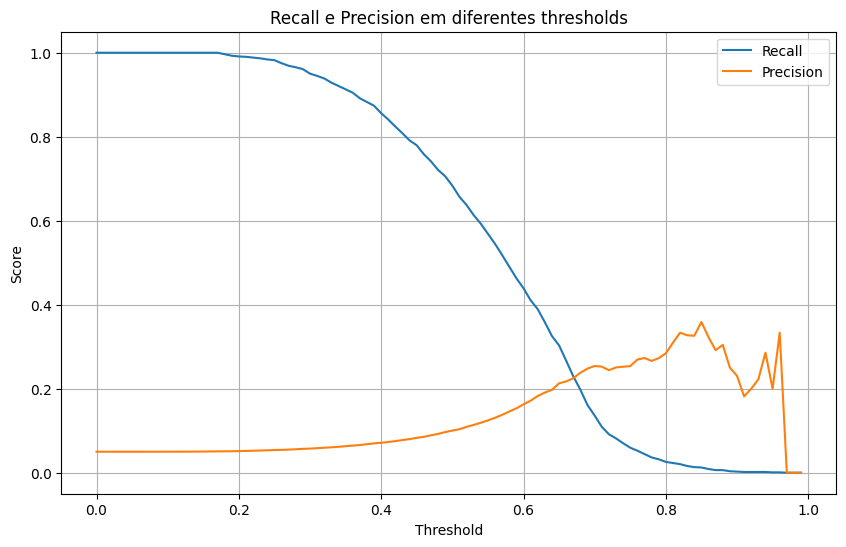

In [21]:
# Definindo listas vazias
thresholds = []
recall_list = []
precision_list = []
earnings = []
loses = []
diff_earnings_loses = []

# Calculando as métricas para cada threshold
for threshold in np.arange(0, 1, 0.01):
    predictions = (pipe.predict_proba(x_teste)[:, 1] >= threshold).astype(int)
    recall = recall_score(y_teste, predictions)
    precision = precision_score(y_teste, predictions)
    recall_list.append(recall)
    precision_list.append(precision)
    thresholds.append(threshold)
    
    conjunto_teste[f"predict_threshold_{str(threshold).replace('.', '_')}"] = predictions
    acertos = conjunto_teste.query(f"fraude == 0 and predict_threshold_{str(threshold).replace('.', '_')} == 0")
    erros = conjunto_teste.query(f"fraude == 1 and predict_threshold_{str(threshold).replace('.', '_')} == 0")
    ganhos = (acertos["valor_compra"] * 0.10).sum()
    perdas = erros["valor_compra"].sum()
    diff_ganhos_perdas = ganhos - perdas
    earnings.append(ganhos)
    loses.append(perdas)
    diff_earnings_loses.append(diff_ganhos_perdas)
    
# Plotando o gráfico    
plt.figure(figsize=(10, 6))
sns.lineplot(x=thresholds, y=recall_list, label='Recall')
sns.lineplot(x=thresholds, y=precision_list, label='Precision')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Recall e Precision em diferentes thresholds')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# Criando um dataframe com os dados
data_metrics = pd.DataFrame({'Thresholds': thresholds, 
                             "Recall":recall_list, 
                             "Precision":precision_list,
                             "Ganho_Bruto":earnings,
                             "Perdas_Com_Fraudes":loses,
                             "Ganho_Líquido":diff_earnings_loses})

In [23]:
# Ordenando pelo modelo que mais trouxe ganhos totais
data_metrics.sort_values("Ganho_Líquido", ascending=False)

,Thresholds,Recall,Precision,Ganho_Bruto,Perdas_Com_Fraudes,Ganho_Líquido
62,0.62,0.389333,0.182652,68438.636,28984.77,39453.866
63,0.63,0.358222,0.190905,69812.134,30540.60,39271.534
57,0.57,0.518222,0.137792,59685.895,21415.16,38270.735
58,0.58,0.490667,0.145723,61813.399,23544.99,38268.409
61,0.61,0.410667,0.171492,66761.063,28499.29,38261.773
...,...,...,...,...,...,...
3,0.03,1.000000,0.050002,3.308,0.00,3.308
4,0.04,1.000000,0.050002,3.308,0.00,3.308
1,0.01,1.000000,0.050000,0.000,0.00,0.000
2,0.02,1.000000,0.050000,0.000,0.00,0.000


O modelo com o threshold de 0.62 foi o que mais trouxe ganho dado apenas o conjunto
de validação.

Agora que já temos o melhor modelo, e sabemos qual o threshold que vai trazer o 
maior retorno, vamos criar uma API que poderia ser acoplada ao um sistema de
transações. 

In [27]:
joblib.dump(pipe, "../models/logistica.pkl")

['../models/logistica.pkl']